# Aims and objectives

## Context

A loan default occurs when a borrower fails to make required payments on their debt. We’ll investigate quantitative factors which contribute to a borrower defaulting on a loan, using exploratory data analysis. We’ll use the insights to decide on approving future loans.

## Aims

We wish to analyse 100 loans to ascertain characteristics of borrowers, and observe any patterns and trends which may be indicative of a borrower being unable to pay back thier loan. We then wish to define a borrower by a set of characteristics, and a loan by a series of control variables. Our target variable is the outcome of the borrower being able to repay the loan. 

Upon the borrower selection process, we wish to minimise the factors which correlate with a borrower being unable to repay the loan. We will also identify and optimise control variables which can minimise risk, proportional to the properties of the borrower's affordability profile.

## Objectives

- What makes a risky borrower?
- What variables can we control to reduce defaults?
- What are the limitations of the data?

## Data dictionary

[Link](https://docs.google.com/spreadsheets/d/1zeaWMqX_PJRR5ikTsY-bV2Hw7pGArNpZhmlsvUjQI18/edit?gid=461848584#gid=461848584) to the data set.
* `credit_policy`: Whether the applicant meets basic credit criteria
* `purpose`: The stated purpose of the loan
* `int_rate`: The interest rate assigned to the loan
* `installment`: Monthly payment amount
* `log_annual_inc`: Natural log of the applicant's annual income
* `dti`: Debt-to-income ratio
* `fico`: FICO credit score
* `days_with_cr_line`: Length of credit history
* `revol_bal`: Revolving balance
* `revol_util`: Revolving utilisation rate
* `inq_last_6mths`: Number of credit inquiries in the last 6 months
* `delinq_2yrs`: Number of delinquencies in the past 2 years
* `pub_rec`: Number of derogatory public records
* `not_fully_paid`: Target variable (1 = unpaid, 0 = paid)

# ETL

## Init

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

## Data extraction and load

In [3]:
df = pd.read_csv('Data_Loan.csv')
df.head(10)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
5,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,0,0,0,0
6,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,0,0,1,1
7,1,all_other,0.1114,131.22,11.002100,11.08,722,5116.000000,24220,68.6,0,0,0,1
8,1,home_improvement,0.1134,87.19,11.407565,17.25,682,3989.000000,69909,51.1,1,0,0,0
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,0,0


Rename columns with `.` to have an `_` separator instead.

In [4]:
df.columns = [c.replace(".", "_") for c in list(df.columns)]

Drop `credit_policy` because it's redundant.

In [5]:
if len(df['credit_policy'].unique()) == 1:
    df = df.drop(labels='credit_policy', axis=1)

Check for null values.

In [6]:
df.isna().any()

purpose              False
int_rate             False
installment          False
log_annual_inc       False
dti                  False
fico                 False
days_with_cr_line    False
revol_bal            False
revol_util           False
inq_last_6mths       False
delinq_2yrs          False
pub_rec              False
not_fully_paid       False
dtype: bool

Cast `not_fully_paid` as boolean.

In [7]:
df['not_fully_paid'] = df['not_fully_paid'].astype('bool')

Data cleansing complete.

In [8]:
df

,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,False
1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,False
2,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,False
3,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,False
4,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,debt_consolidation,0.0775,156.11,10.714418,5.00,762,2131.000000,1359,5.6,2,0,0,False
96,debt_consolidation,0.1154,329.95,12.323856,20.00,727,10292.000000,107501,44.8,2,0,0,False
97,all_other,0.0807,313.67,12.061047,0.72,787,8010.000000,3054,5.6,3,0,0,False
98,all_other,0.0807,297.99,11.407565,2.44,792,8717.958333,40384,9.6,0,0,0,False


## Data transformation

### Schema

Preview values in dataset to determine categorical vs numerical modelling.

In [9]:
for col in df:
    unique_values = df[col].unique()
    #if len(unique_values) <= 10:
    print(f"Column: {col}")
    print("Unique values:", unique_values, "\n")

Column: purpose
Unique values: ['debt_consolidation' 'credit_card' 'all_other' 'home_improvement'
 'small_business' 'major_purchase' 'educational'] 

Column: int_rate
Unique values: [0.1189 0.1071 0.1357 0.1008 0.1426 0.0788 0.1496 0.1114 0.1134 0.1221
 0.1347 0.1324 0.0859 0.0714 0.0863 0.1103 0.1317 0.0894 0.1039 0.1513
 0.08   0.1355 0.1229 0.0901 0.0743 0.1375 0.0807 0.1028 0.087  0.1122
 0.0996 0.0933 0.0838 0.0775 0.1059 0.1596 0.1154 0.1343 0.1249 0.0964
 0.1186 0.1501 0.128  0.1091 0.1217 0.1533] 

Column: installment
Unique values: [829.1  228.22 366.86 162.34 102.92 125.13 194.02 131.22  87.19  84.12
 360.43 253.58 316.11  92.82 209.54 327.53  77.69 476.58 584.12 173.65
 188.02 474.42 339.6  484.85 320.19 159.03 155.38 255.43 156.84 275.38
  78.42 158.3  164.23 161.25 159.77  94.98  97.2  167.02 168.6  160.72
 178.69 323.98 813.65 112.87  94.88 398.69  39.6  678.08 401.37 205.45
 397.75 113.39  99.44 109.79  32.55 160.51 340.57 156.11 235.25 257.99
 225.37  80.26  84.   507.4

### Categorical data

In [10]:
df_cat = pd.DataFrame([
    df['purpose'],
    df['inq_last_6mths'].astype("category"),
    df['delinq_2yrs'].astype("category"),
    df['pub_rec'].astype("category")
]).T
df_cat

,purpose,inq_last_6mths,delinq_2yrs,pub_rec
0,debt_consolidation,0,0,0
1,credit_card,0,0,0
2,debt_consolidation,1,0,0
3,debt_consolidation,1,0,0
4,credit_card,0,1,0
...,...,...,...,...
95,debt_consolidation,2,0,0
96,debt_consolidation,2,0,0
97,all_other,3,0,0
98,all_other,0,0,0


We exclude `not_fully_paid` since it's our target variable. Instead, we'll use it as a filter.

### Numerical data

In [11]:
df_num = pd.DataFrame([
    df['int_rate'],
    df['installment'],
    df['log_annual_inc'],
    df['dti'],
    df['days_with_cr_line'],
    df['revol_bal'],
    df['revol_util'],
    df['fico']
]).T
df_num

,int_rate,installment,log_annual_inc,dti,days_with_cr_line,revol_bal,revol_util,fico
0,0.1189,829.10,11.350407,19.48,5639.958333,28854.0,52.1,737.0
1,0.1071,228.22,11.082143,14.29,2760.000000,33623.0,76.7,707.0
2,0.1357,366.86,10.373491,11.63,4710.000000,3511.0,25.6,682.0
3,0.1008,162.34,11.350407,8.10,2699.958333,33667.0,73.2,712.0
4,0.1426,102.92,11.299732,14.97,4066.000000,4740.0,39.5,667.0
...,...,...,...,...,...,...,...,...
95,0.0775,156.11,10.714418,5.00,2131.000000,1359.0,5.6,762.0
96,0.1154,329.95,12.323856,20.00,10292.000000,107501.0,44.8,727.0
97,0.0807,313.67,12.061047,0.72,8010.000000,3054.0,5.6,787.0
98,0.0807,297.99,11.407565,2.44,8717.958333,40384.0,9.6,792.0


# EDA

In [94]:
sns.set_theme()

## Univariate

### Descriptive statistics

#### Paid loans

In [13]:
df_num[df['not_fully_paid'] == False].describe()

,int_rate,installment,log_annual_inc,dti,days_with_cr_line,revol_bal,revol_util,fico
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.098923,223.491778,11.092679,8.763889,4634.350000,17188.522222,33.861111,729.444444
std,0.022623,151.752754,0.711382,5.957935,2701.846875,23392.569414,26.019797,45.160416
min,0.071400,39.600000,8.987197,0.000000,1126.958333,0.000000,0.000000,627.000000
25%,0.080700,125.950000,10.626080,3.467500,2699.958333,3097.250000,13.775000,694.500000
50%,0.093300,160.615000,11.177233,7.985000,4182.000000,7059.000000,26.200000,727.000000
75%,0.112200,297.990000,11.512925,14.350000,5939.750000,21950.250000,51.950000,767.000000
max,0.159600,829.100000,12.429216,22.090000,14008.958330,128000.000000,93.400000,812.000000


Summary (n=90)
| Measure                    | Average | Min    | Max      |
|----------------------------|---------|--------|----------|
| Interest rate              | 0.099   | 0.071  | 0.160    |
| Installment amount         | £223.50 | £39.60 | £829.10  |
| Log of annual income       | 11.1    | 8.99   | 12.4     |
| Debt-to-income ratio       | 8.76    | 0      | 22.1     |
| Days with credit line      | 4634    | 1127   | 14009    |
| Revolving balance          | £17,189 | £0     | £128,000 |
| Revolving utilisation rate | 33.9    | 0      | 93.4     |
| FICO credit score          | 729     | 627    | 812      |

#### Unpaid loans

In [14]:
df_num[df['not_fully_paid'] == True].describe()

,int_rate,installment,log_annual_inc,dti,days_with_cr_line,revol_bal,revol_util,fico
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.119970,267.974000,10.958715,11.475000,3911.787500,15398.200000,50.250000,701.000000
std,0.019775,245.534131,0.783348,5.927931,1850.599204,19257.530734,23.900918,33.977116
min,0.096400,32.550000,9.615805,2.860000,1110.000000,269.000000,3.800000,667.000000
25%,0.107275,89.190000,10.474525,7.375000,2437.510417,3515.750000,35.550000,678.250000
50%,0.113800,162.620000,10.858259,11.660000,4565.458333,5499.000000,48.800000,684.500000
75%,0.132725,436.937500,11.410388,14.227500,5305.718750,20739.000000,72.725000,719.500000
max,0.150100,678.080000,12.269047,20.000000,6240.000000,56411.000000,76.800000,772.000000


Summary (n=10)
| Measure                    | Average | Min    | Max      |
|----------------------------|---------|--------|----------|
| Interest rate              | 0.120   | 0.096  | 0.150    |
| Installment amount         | £267.97 | £32.55 | £678.08  |
| Log of annual income       | 11.0    | 9.62   | 12.3     |
| Debt-to-income ratio       | 11.5    | 2.86   | 20.0     |
| Days with credit line      | 3912    | 1110   | 6240     |
| Revolving balance          | £15,398 | £269   | £56,411  |
| Revolving utilisation rate | 50.3    | 3.8    | 76.8     |
| FICO credit score          | 701     | 667    | 772      |

### Data distribution

#### Categorical data

Proportion of categories in `False` or `True`:

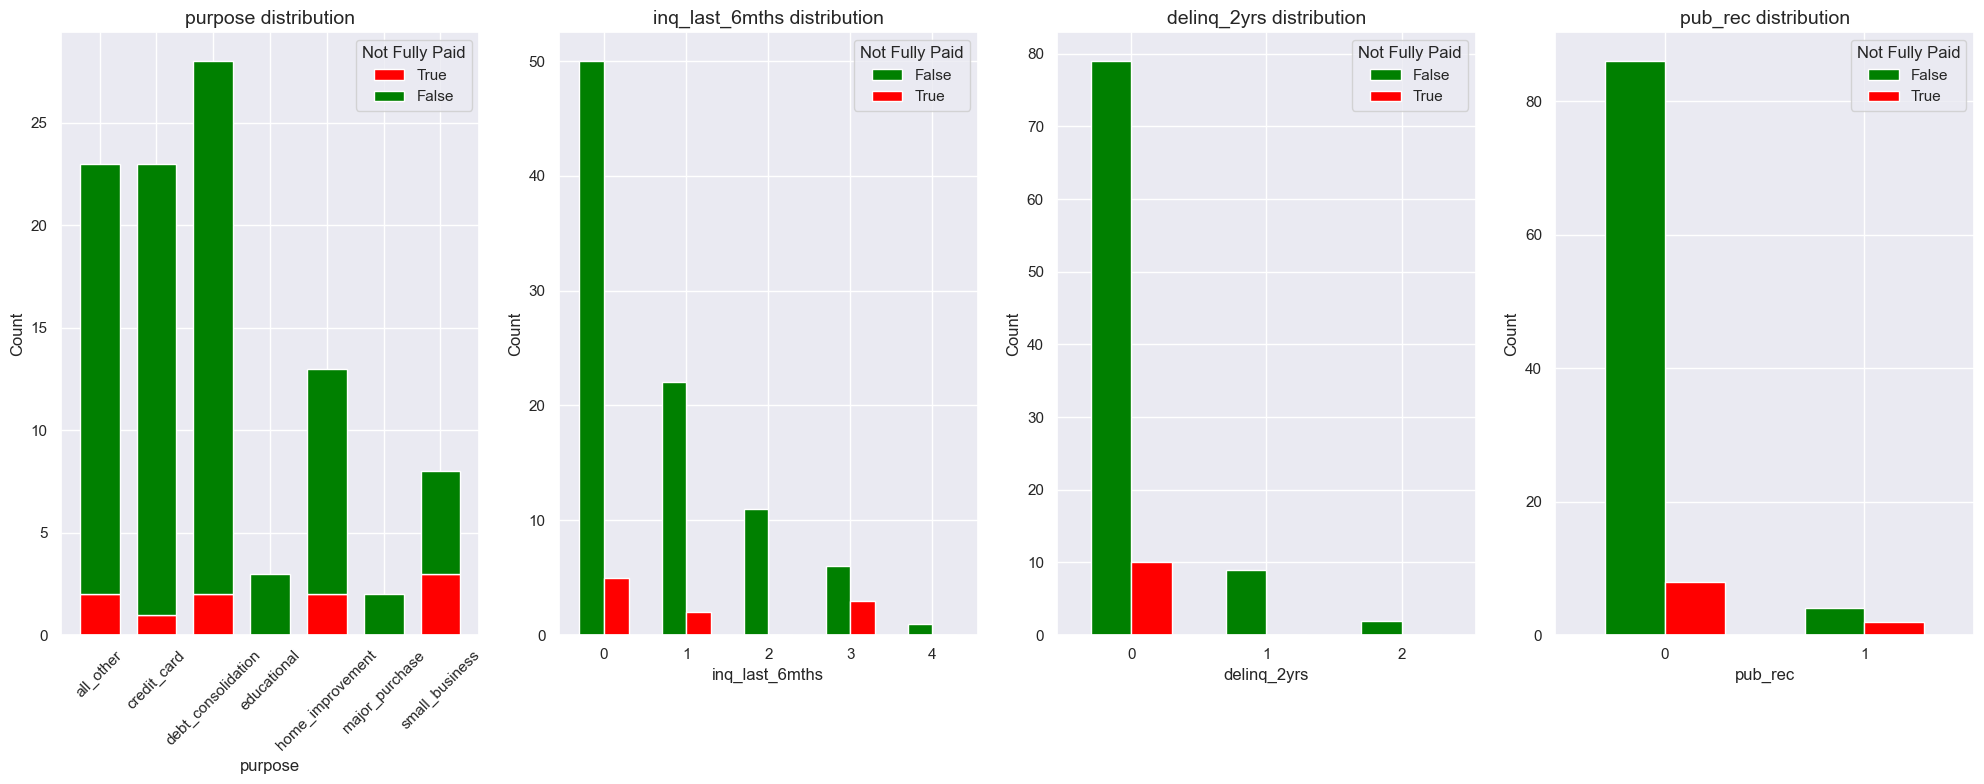

In [15]:
# Define columns to plot
columns = df_cat.columns

# Define a color palette
palette = {False: 'green', True: 'red'}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(20, 8))

for ax, col in zip(axes, columns):
    # Group and sort values for better clarity
    sorted_counts = df.groupby([col, 'not_fully_paid']).size().unstack().fillna(0)
    
    if col == 'purpose':
        # Calculate proportions for stacking
        bottom = sorted_counts[False]
        
        # Plot stacked bar plot for 'purpose'
        ax.bar(sorted_counts.index, sorted_counts[True], color=palette[True], label='True', width=0.7)
        ax.bar(sorted_counts.index, sorted_counts[False], bottom=sorted_counts[True], color=palette[False], label='False', width=0.7)
        ax.set_title(f'{col} distribution', fontsize=14)
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
    else:
        # Plot individual bar plot for other columns
        sorted_counts.plot(kind='bar', stacked=False, color=[palette[False], palette[True]], ax=ax, width=0.6)
        ax.set_title(f'{col} distribution', fontsize=14)
        ax.tick_params(axis='x', rotation=0)  # Keep x-axis labels horizontal
    
    # Customize each subplot
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='Not Fully Paid', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

#### Numerical data

/var/folders/w0/mkf6nqcx2_s0xg85xfrzd05h0000gn/T/ipykernel_85796/1549638171.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.0)


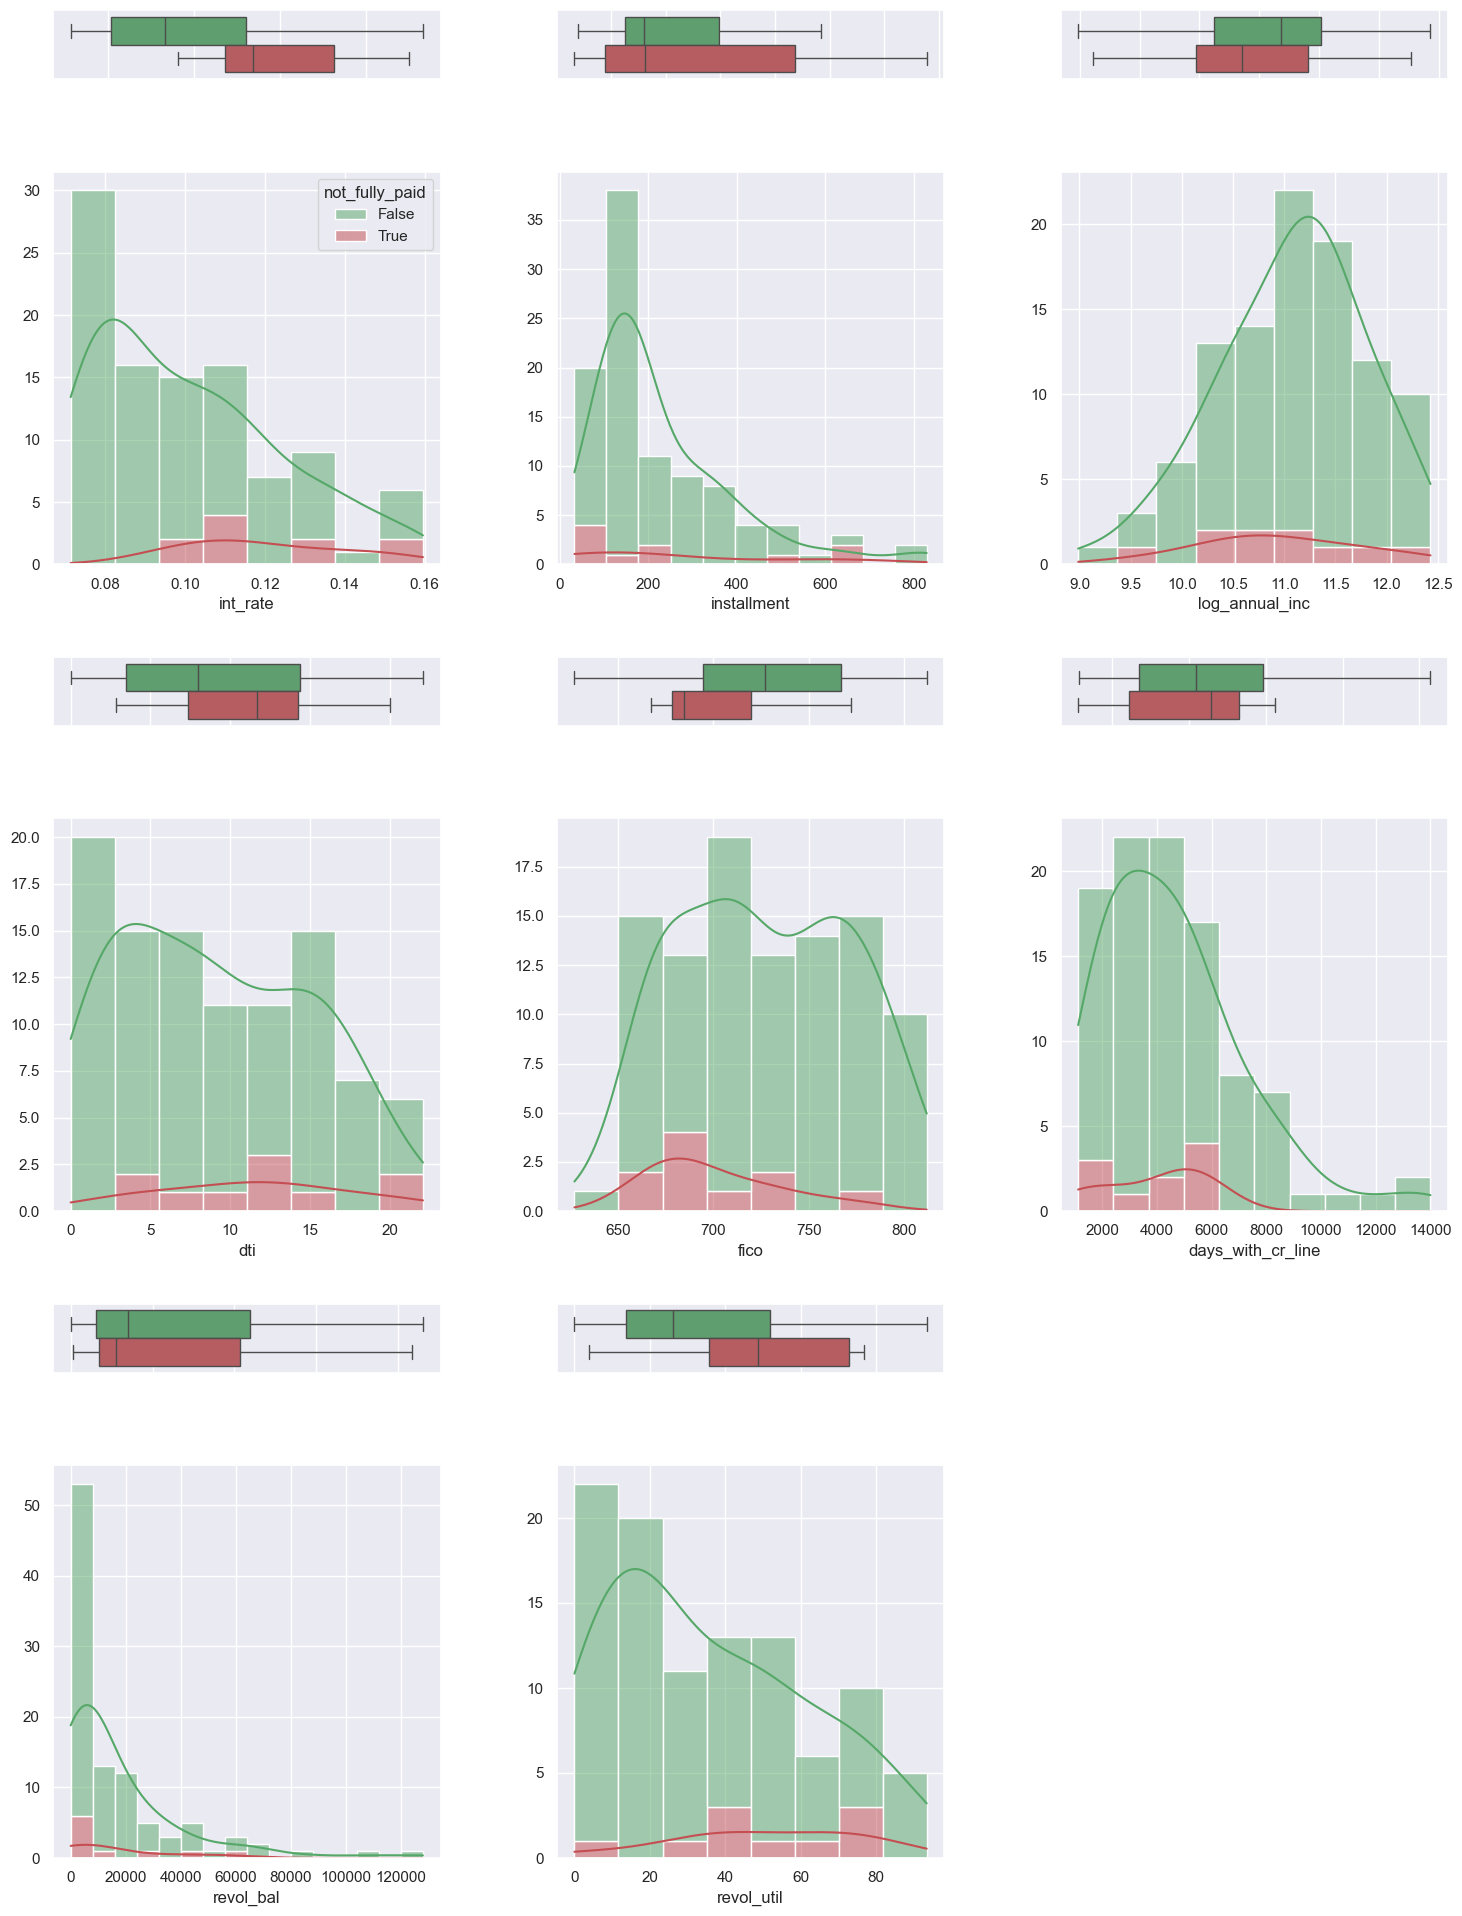

In [16]:
palette = {True: 'r', False: 'g'}
num_cols = 3  # Number of columns per row

# Filter only numerical columns and exclude 'not_fully_paid' and categorical columns
numerical_columns = [col for col in df.select_dtypes(include=['number']).columns if col != 'not_fully_paid' and col not in df_cat]

# Calculate the number of rows needed
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

# Adjust the height of the figure and set wspace and hspace for desired spacing
fig, axes = plt.subplots(num_rows * 2, num_cols, figsize=(18, num_rows * 8), gridspec_kw={"height_ratios": [0.15, 0.85] * num_rows, "wspace": 0.3, "hspace": 0.4})

for i, col in enumerate(numerical_columns):
    row = (i // num_cols) * 2  # Determine which row pair to work on
    col_idx = i % num_cols     # Determine the column index within the grid
    
    # Create the boxplot on top with a slim y-axis
    sns.boxplot(data=df, x=col, hue='not_fully_paid', palette=palette, ax=axes[row, col_idx], showfliers=False, legend=False)
    axes[row, col_idx].set(ylabel='', xlabel='')  # Remove labels
    axes[row, col_idx].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-axis labels for box plot

    # Create the histogram below the boxplot
    sns.histplot(data=df, x=col, hue='not_fully_paid', multiple='stack', kde=True, palette=palette, ax=axes[row + 1, col_idx], legend=(i == 0))
    axes[row + 1, col_idx].set(ylabel='')  # Remove y-axis label

# Remove empty subplots if the number of columns is not a perfect multiple of num_cols
for j in range(len(numerical_columns), num_rows * num_cols):
    fig.delaxes(axes[(j // num_cols) * 2, j % num_cols])
    fig.delaxes(axes[(j // num_cols) * 2 + 1, j % num_cols])

plt.tight_layout(pad=2.0)
plt.show()

#### Skew analysis

|              | Paid                                                      | Unpaid                                                       |
|--------------|-----------------------------------------------------------|--------------------------------------------------------------|
| **Positive** | int_rate<br>installment<br>dti<br>revol_bal<br>revol_util | int_rate<br>installment<br>log_annual_inc<br>fico<br>revol_bal<br>revol_util |
| **Negative** | log_annual_inc                                            | days_with_cr_line<br>dti                                     |

Key: 
- Positive indicates outliers at higher values
- Negative indicates outliers at lower values

#### Chi-squared test

In [17]:
# Prepare a list to store the results
results_list = []

for col in df.columns:
    if col != 'not_fully_paid':  # Skip the target variable itself
        # Create a contingency table
        contingency_table = pd.crosstab(df[col], df['not_fully_paid'])
        
        # Perform the Chi-Squared test
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Append the results to the list
        results_list.append({
            "Category": col,
            "Chi2 Statistic": chi2,
            "p-value": p,
            "DoF": dof
        })

# Convert the list to a DataFrame
chi2_results = pd.DataFrame(results_list)

# Sorting the results by p-value for easier interpretation
chi2_results = chi2_results.sort_values(by="p-value").reset_index(drop=True)

# Display the DataFrame
chi2_results

,Category,Chi2 Statistic,p-value,DoF
0,int_rate,62.962963,0.039551,45
1,installment,100.000000,0.086070,82
2,inq_last_6mths,6.902357,0.141139,4
3,purpose,8.810453,0.184522,6
4,pub_rec,1.595745,0.206507,1
5,days_with_cr_line,100.000000,0.221040,90
6,revol_util,100.000000,0.266866,92
7,revol_bal,100.000000,0.342833,95
8,log_annual_inc,60.555556,0.383766,58
9,dti,92.592593,0.404772,90


After an evaluation of the $\chi^2$ test, only the `int_rate` category had a $p<0.05$. This suggests that `int_rate` was the only distribution which had a significant influence on whether a loan could be repaid or not.

## Bivariate

### Pair plots

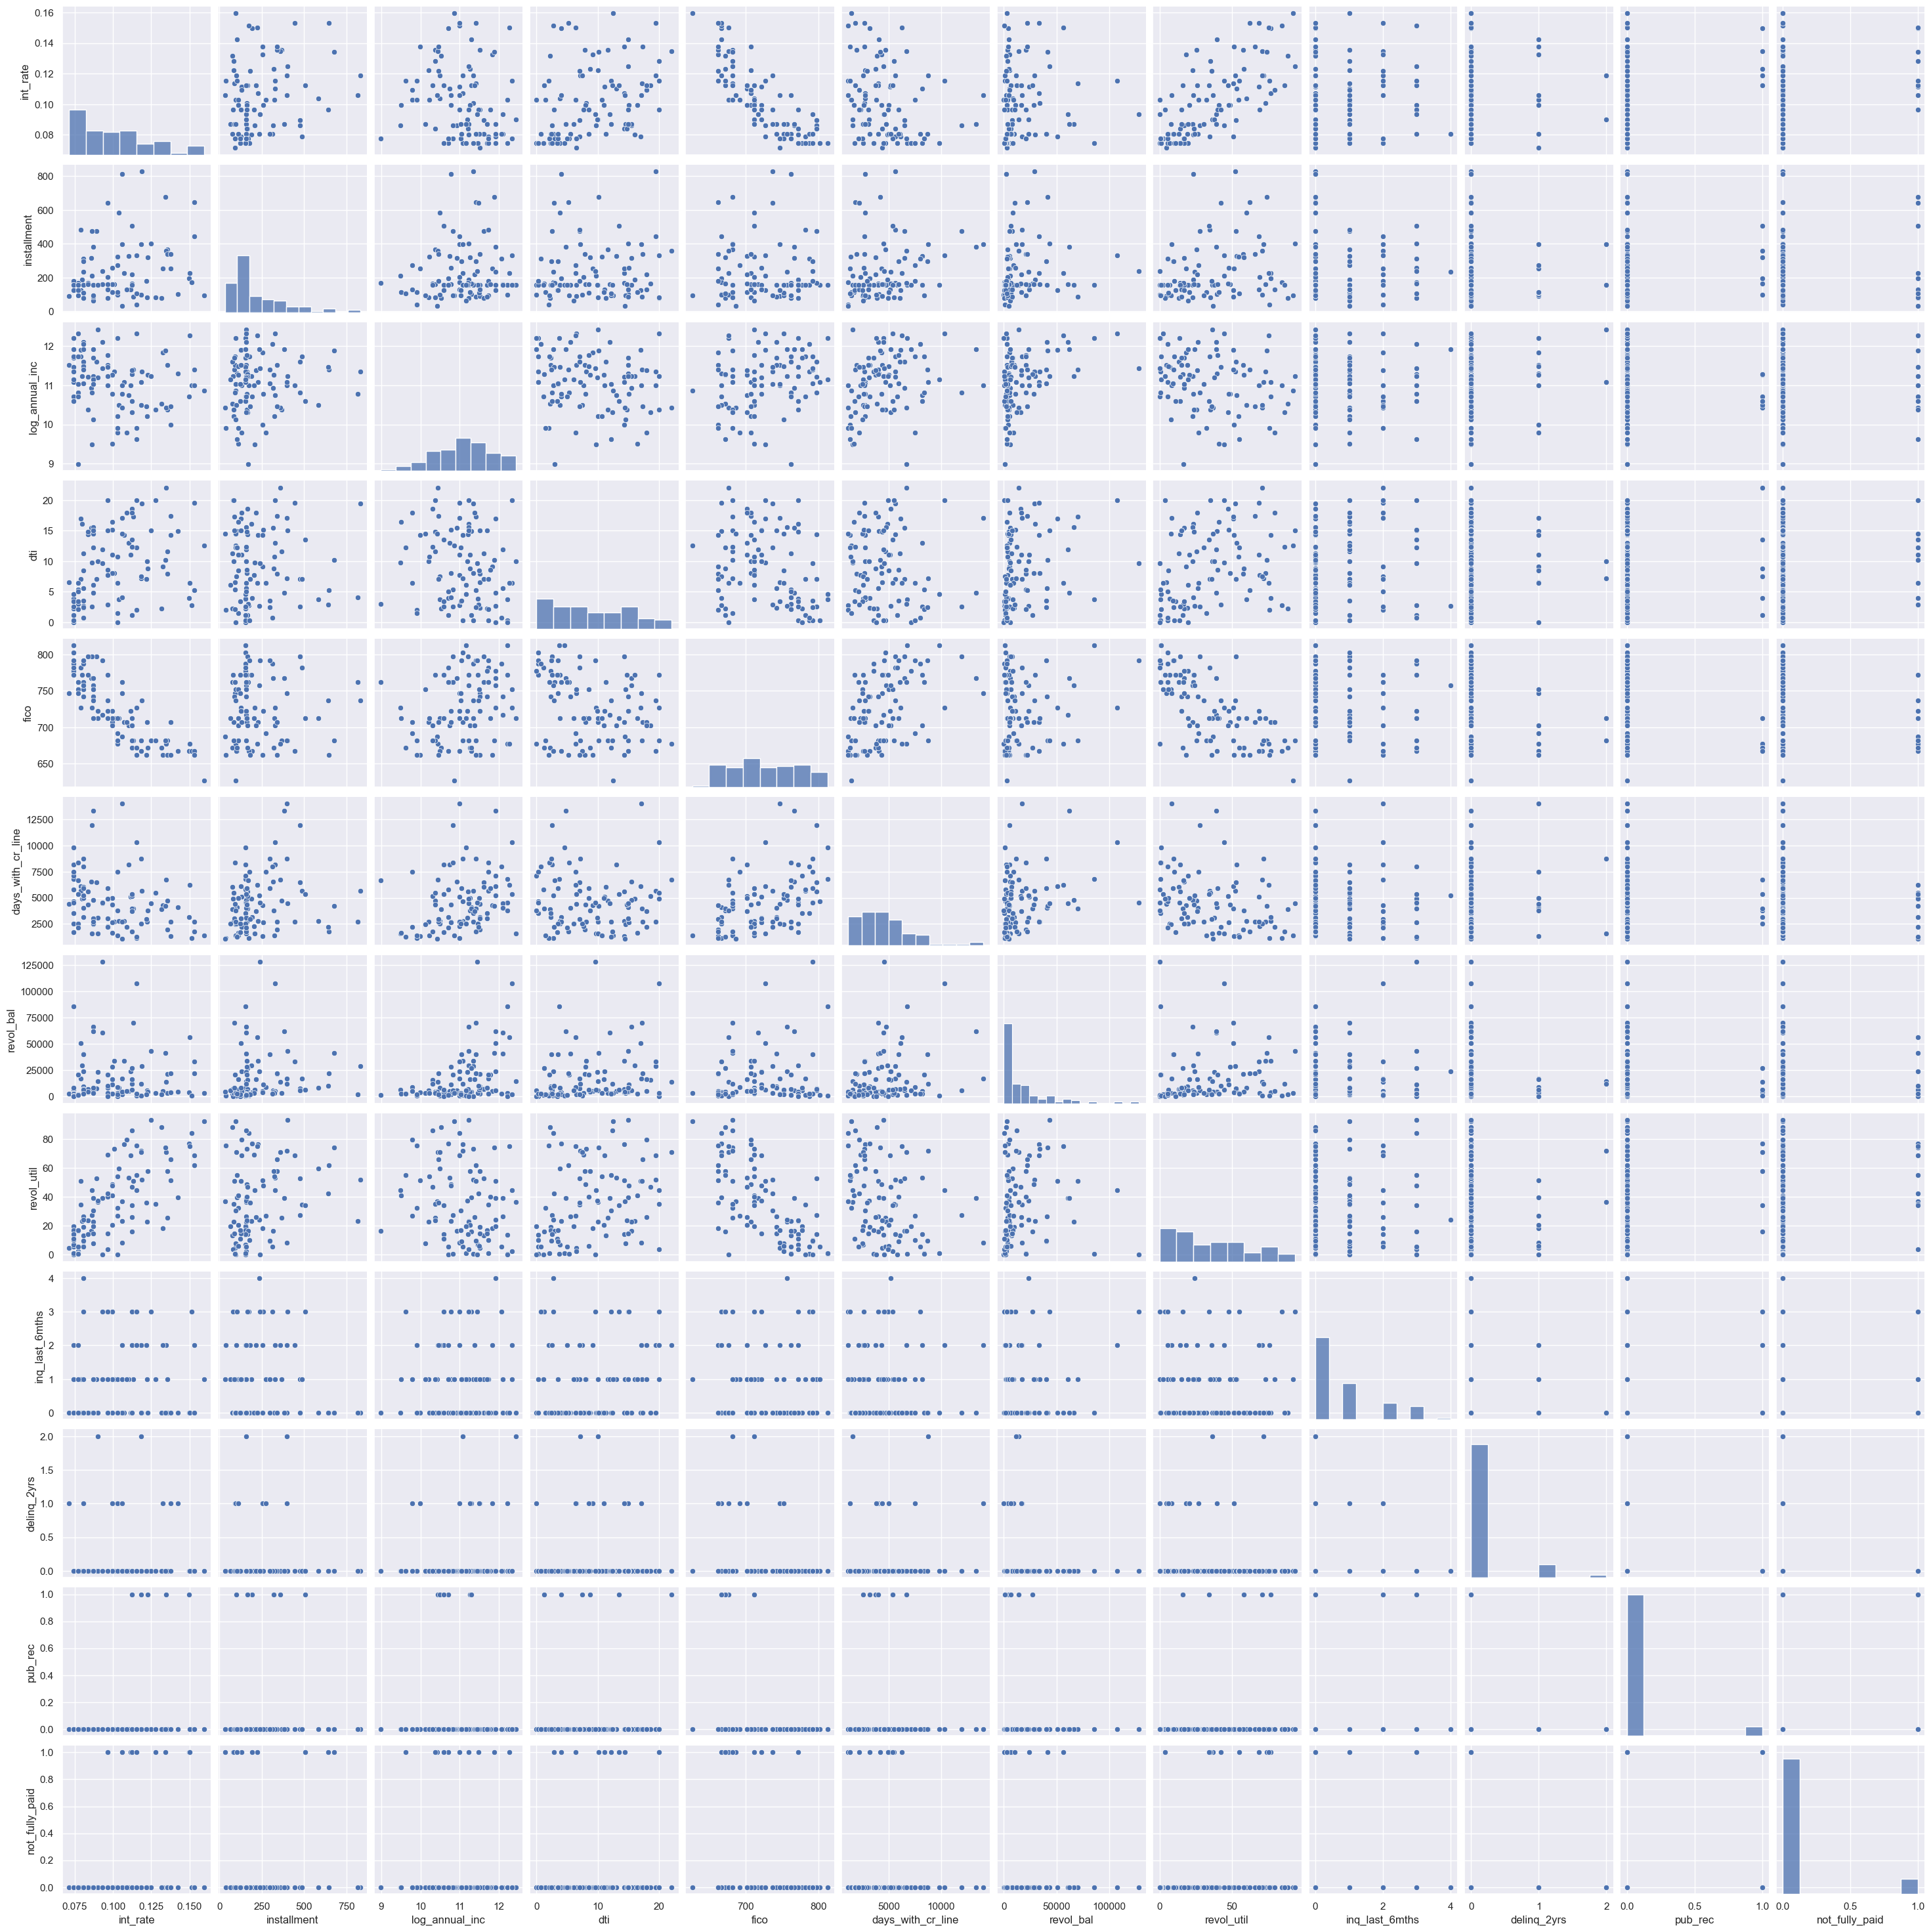

In [18]:
sns.pairplot(df)

That's a lot of data! Let's simplify our correlation analysis using heat maps. We can draw pair plots on any interesting correlations for a more detailed look.

### Heat maps

/var/folders/w0/mkf6nqcx2_s0xg85xfrzd05h0000gn/T/ipykernel_85796/2483184949.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='grey', edgecolor='white', lw=0.5))


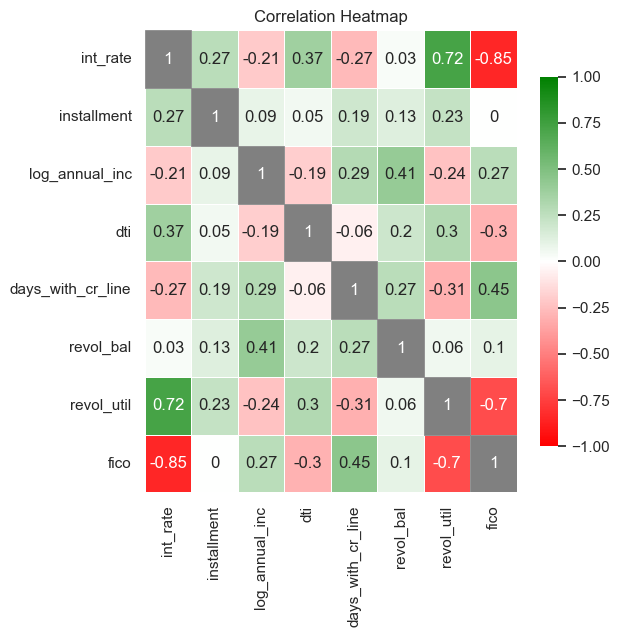

In [119]:
from matplotlib.colors import LinearSegmentedColormap

# Compute the correlation matrix and round it to 2 decimal places
corr_matrix = round(df_num.corr(), 2)

# Create a custom colormap from red to white to green
cmap = LinearSegmentedColormap.from_list('custom_cmap',
                                         ['red', 'white', 'green'],
                                         N=256)

# Plot the heatmap
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap=cmap, center=0, vmin=-1, vmax=1, 
                      linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8})

# Grey out the values equal to 1
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if corr_matrix.iloc[i, j] == 1:
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='grey', edgecolor='white', lw=0.5))

# Customize the heatmap
plt.title('Correlation Heatmap')
plt.show()

Let's scope into `not_fully_paid` and draw a heatmap to check for significant trends between the two.

/var/folders/w0/mkf6nqcx2_s0xg85xfrzd05h0000gn/T/ipykernel_85796/3914737858.py:30: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  heatmap_true.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='grey', edgecolor='white', lw=0.5))
/var/folders/w0/mkf6nqcx2_s0xg85xfrzd05h0000gn/T/ipykernel_85796/3914737858.py:41: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  heatmap_false.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='grey', edgecolor='white', lw=0.5))


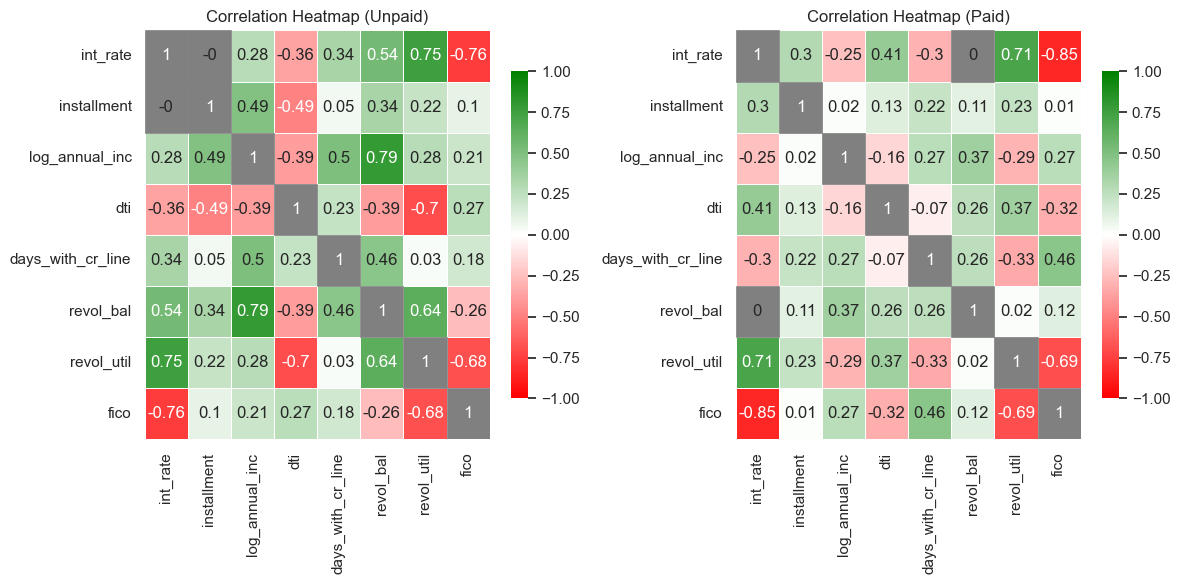

In [122]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming df_num contains the numerical variables and df contains the 'not_fully_paid' column

# Separate the data into True and False subsets
df_num_true = df_num[df['not_fully_paid'] == True]
df_num_false = df_num[df['not_fully_paid'] == False]

# Compute the correlation matrix for each subset and round it to 2 decimal places
corr_matrix_true = round(df_num_true.corr(), 2)
corr_matrix_false = round(df_num_false.corr(), 2)

# Create a custom colormap from red to white to green
cmap = LinearSegmentedColormap.from_list('custom_cmap',
                                         ['red', 'white', 'green'],
                                         N=256)

# Set up the subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the heatmap for the True subset
heatmap_true = sns.heatmap(corr_matrix_true, annot=True, cmap=cmap, center=0, vmin=-1, vmax=1, 
                           linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8}, ax=axes[0])
axes[0].set_title('Correlation Heatmap (Unpaid)')

# Grey out the values equal to 1 or 0
for i in range(len(corr_matrix_true)):
    for j in range(len(corr_matrix_true)):
        if corr_matrix_true.iloc[i, j] == 1 or corr_matrix_true.iloc[i, j] == 0:
            heatmap_true.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='grey', edgecolor='white', lw=0.5))

# Plot the heatmap for the False subset
heatmap_false = sns.heatmap(corr_matrix_false, annot=True, cmap=cmap, center=0, vmin=-1, vmax=1, 
                            linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8}, ax=axes[1])
axes[1].set_title('Correlation Heatmap (Paid)')

# Grey out the values equal to 1 or 0
for i in range(len(corr_matrix_false)):
    for j in range(len(corr_matrix_false)):
        if corr_matrix_false.iloc[i, j] == 1 or corr_matrix_false.iloc[i, j] == 0:
            heatmap_false.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='grey', edgecolor='white', lw=0.5))

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

### Significant pair plots

Highlight plots with PCC >= 0.3

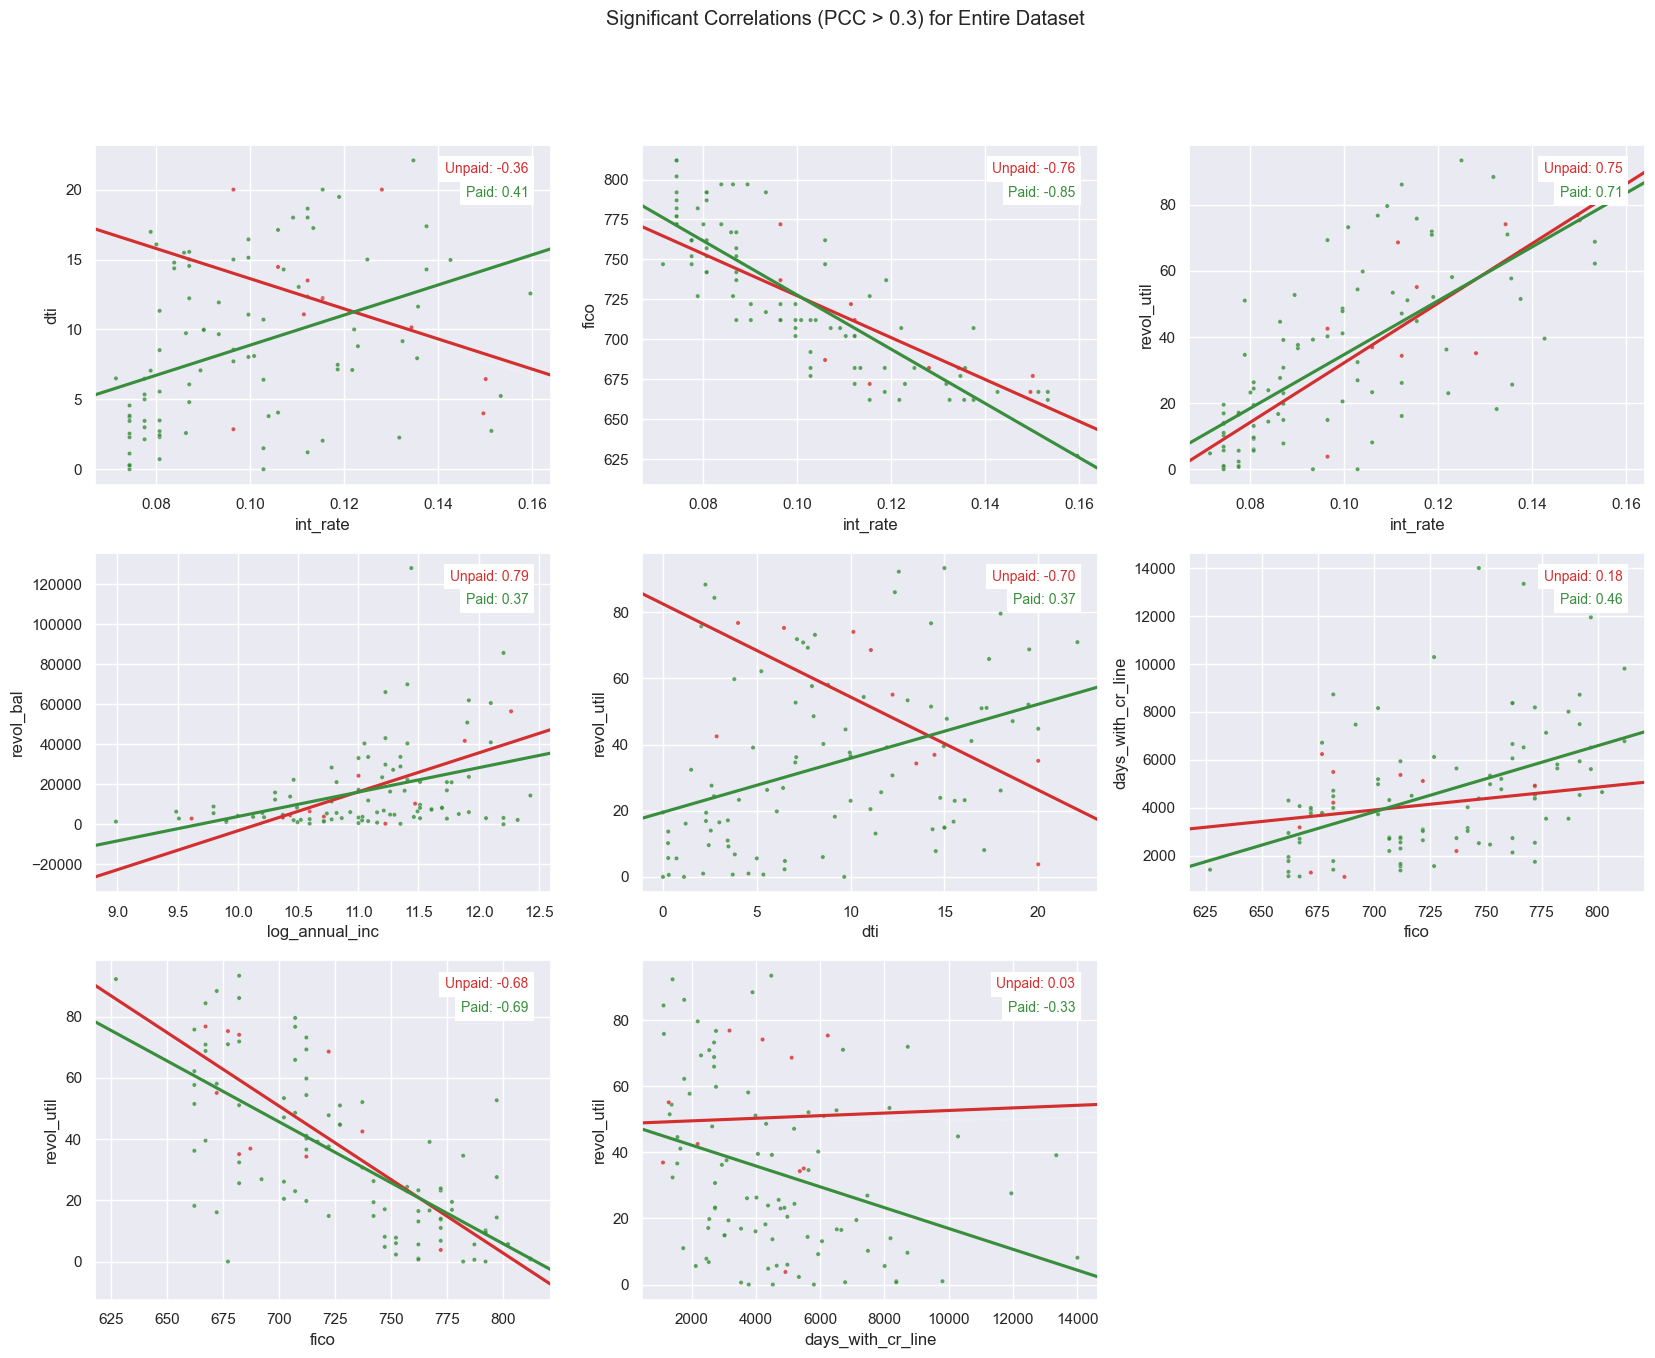

In [116]:
def get_significant_correlations(data, hue):
    # Compute the correlation matrix
    num_cols = data.select_dtypes(include=['number']).columns
    num_cols = [col for col in num_cols if col != hue]
    corr_matrix = data[num_cols].corr()

    significant_pairs = []

    # Identify significant correlations
    for i, x in enumerate(num_cols):
        for j, y in enumerate(num_cols):
            if i < j:  # Avoid redundant plotting
                corr = corr_matrix.loc[x, y]
                if abs(corr) >= 0.3:
                    significant_pairs.append((x, y, corr))

    return significant_pairs, corr_matrix

def plot_significant_correlations(unpaid_status, data, significant_pairs, hue, palette):
    # Define colour mapping for the dots
    dot_palette = {True: '#d32f2f', False: '#388e3c'}  # Darker red and green

    # Create a single figure to collate significant graphs
    num_plots = len(significant_pairs)
    rows = int(np.ceil(num_plots / 3))
    
    fig, axes = plt.subplots(rows, 3, figsize=(20, rows * 5), sharex=False, sharey=False)
    axes = axes.flatten()

    # Plot significant correlations
    for i, (x, y, corr) in enumerate(significant_pairs):
        ax = axes[i]
        sns.scatterplot(data=data, x=x, y=y, hue=hue, palette=dot_palette, ax=ax, s=10, alpha=0.8)

        if unpaid_status not in [0, 1]:
            # Plot regression lines
            sns.regplot(data=data[data['not_fully_paid'] == True], x=x, y=y, scatter=False, ax=ax, color=dot_palette.get(True), truncate=False, ci=0)
            sns.regplot(data=data[data['not_fully_paid'] == False], x=x, y=y, scatter=False, ax=ax, color=dot_palette.get(False), truncate=False, ci=0)
            
            # Add correlation coefficient text in the top-right corner
            ax.text(0.95, 0.95, f'Unpaid: {data[[x, y]][data[hue] == True].corr().iloc[0, 1]:.2f}', 
                    transform=ax.transAxes, ha='right', va='top', fontsize=10, color=dot_palette.get(True), bbox=dict(facecolor='white', edgecolor='none'))
            ax.text(0.95, 0.88, f'Paid: {data[[x, y]][data[hue] == False].corr().iloc[0, 1]:.2f}', 
                    transform=ax.transAxes, ha='right', va='top', fontsize=10, color=dot_palette.get(False), bbox=dict(facecolor='white', edgecolor='none'))

        else:
            # Add correlation coefficient text in the top-right corner
            ax.text(0.95, 0.95, f'{corr:.2f}', transform=ax.transAxes,
                    ha='right', va='top', fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none'))

        # Set background opacity based on correlation strength
        #ax.patch.set_alpha(abs(corr))

        # Remove legend from all but the first plot
        #if i != 0:
        ax.get_legend().remove()

    # Hide any unused subplots
    for ax in axes[num_plots:]:
        ax.axis('off')

    if unpaid_status == 1:
        plt.suptitle('Significant Correlations for Paid Loans', y=0.97)
    elif unpaid_status == 0:
        plt.suptitle('Significant Correlations for Unpaid Loans', y=0.97)
    else:
        plt.suptitle('Significant Correlations (PCC > 0.3) for Entire Dataset', y=0.97)

    plt.show()

# Define colour palette for 'True' and 'False'
palette = {True: '#ff9999', False: '#99ff99'}  # Pastel red and green

# Get significant correlations
#significant_pairs, corr_matrix = get_significant_correlations(df[df['not_fully_paid']==False], hue='not_fully_paid')
#filtered_pairs = [(x, y, corr) for x, y, corr in significant_pairs if len(df[x].unique()) > 10 and len(df[y].unique()) > 10]
#plot_significant_correlations(0, df[df['not_fully_paid']==False], filtered_pairs, hue='not_fully_paid', palette=palette)

#significant_pairs, corr_matrix = get_significant_correlations(df[df['not_fully_paid']==True], hue='not_fully_paid')
#filtered_pairs = [(x, y, corr) for x, y, corr in significant_pairs if len(df[x].unique()) > 10 and len(df[y].unique()) > 10]
#plot_significant_correlations(1, df[df['not_fully_paid']==True], filtered_pairs, hue='not_fully_paid', palette=palette)


significant_pairs, corr_matrix = get_significant_correlations(df, hue='not_fully_paid')
filtered_pairs = [(x, y, corr) for x, y, corr in significant_pairs if len(df[x].unique()) > 10 and len(df[y].unique()) > 10]
plot_significant_correlations(-1, df, filtered_pairs, hue='not_fully_paid', palette=palette)




# Report

### Methodology

A CSV data set of 100 loans was loaded into Python using the Pandas module. The data was cleansed and transformed to remove redundant columns, and remaining ones were sorted into categorical and numerical subsets `df_cat` and `df_num`.

Within these subsets, fundamental statistics were obtained, with univariate and bivariate analysis following to investigate the factors that contribute to `not_fully_paid` being `False`.

**Notes on the data:**
- Log of annual income of borrower is used to factor out [diminishing returns](https://typeset.io/questions/why-use-log-of-household-income-when-estimating-the-1n2q29zfle#) on the impact of wellbeing as a household’s wealth increases
- We assume the currency is in GPB

**Notes on sample size:**
- Of 100 loans surveyed, 10 were unpaid. The sample is very small. An obvious suggestion would be using more data points, particularly since univariate analysis can yield unreliable results. Using a larger figure such as 1000 loans would yield a better sample size.
- We could look at the problem from the opposite perspective, analysing what contributes to an outcome of `not_fully_paid` being `True`. We could the cross-validate these factors by matching their inverse cases against `False` cases. 

**Outline of method:**
- Data cleansing and transformation
- Univariate analysis
  - Descriptive statistics
  - Histogram, KDE and box plots
  - Chi-squared Test
- Bivariate analysis
  - Pair plots
  - Heat maps
  - Significant pair plots

### Results, discussion and insights

The purpose of the EDA is to inspire informed research. By analysing the statistical properties of a data set, we know *what* to research to find out *why* something is happening. In a real scenario, this would involve directly enquiring through the relevant channels to find out where the bottleneck is occuring, armed with preliminary information to guide where to look for the fault. The inverse can be said for optimisation.

#### Univariate analysis

Cateogorical analysis:
- Riskiest loan purpose was `small_business`. It's known that 20% of SMEs [fail](https://www.fundera.com/blog/what-percentage-of-small-businesses-fail?irclickid=VGYUPwQiDxyPTttTo82DI0LWUkHwq3RpRXgn3c0&utm_campaign=Skimbit%20Ltd._10078&utm_source=Impact&utm_content=Online%20Tracking%20Link&utm_medium=affiliate&irgwc=1#sources) in their first year, with only 50% surviving five.
- All `home_improvement` and `educational` loans were fully repaid. However, there's only a few of these.
- There's no significant relationship between `delinq_2yrs` and defaults.
- A risky borrower is five times more likely to have a degoratory `pub_rec` against them versus one who hasn't defaulted. 

Numerical distribution:
- Outliers for paid borrowers
  -  **High values:** `int_rate`, `installment` amounts, `dti`, `revol_bal` and `revol_util`
  -  **Low values:** `log_annual_inc`
- Outliers for unpaid borrowers 
  - **High values:**  `int_rate`, `installment`, `log_annual_inc`, `fico`, `revol_bal` and `revol_util` 
  - **Low values:** `dti`, `days_with_cr_line`,

Insights from outlier distribution:

- Borrowers who could replay their loan were less likely to have a high `dti`. They were also on the higher end of `log_annual_inc`. There was a more even distribution of `fico` and `days_with_cr_line` between these borrowers, however there was also more data.
- Borrowers who defaulted had a lower `fico` and `log_annual_inc`, but higher `dti` and `days_with_cr_line`.
- In all cases, high `int_rate`, `revol_bal`, `revol_util`, and `installment` amounts were rare. 

Chi2 test:
- A significant control variable to adjust is `int_rate`, since p < 0.05.

**Conclusion:**
- A *good* borrower typically posesses a low DTI, and a higher log annual income.
- A *bad* borrower has a lower FICO credit score, a lower log annual income, and a higher DTI, as well as longer credit line duration. 
- A *bad* borrower is also far more likely to hold degoratory public records against them.
- Small businesses are riskier to lend to: approximately 40% of these defaulted.
- We didn't charge high interest rates or installments for any buyers. We *could* adjust this if we discover anything significant in correlation analysis, primarily focussing on interest rate having been found significant from the $\chi^2$ test.

#### Bivariate analysis

We set our significance threshold to PCC > 0.3 in either direction.

The following significant correlations were found:

| **Correlation Pair**                                | **Paid** | **Unpaid** |
|-----------------------------------------------------|----------|------------|
| DTI and interest rate                               | +0.41    | -0.36      |
| FICO score and interest rate                        | -0.85    | -0.76      |
| Revolving balance and log annual income             | +0.37    | +0.79      |
| Revolving utilisation rate and DTI                  | +0.37    | -0.70      |
| Revolving utilisation rate and interest rate        | +0.71    | +0.75      |
| FICO score and days with credit line                | +0.46    |            |
| Revolving utilisation rate and FICO score           | -0.69    | -0.68      |
| Revolving utilisation rate and days with credit line| -0.33    |            |

**Insights:** 
- We didn't charge enough interest on applicants with a low DTI, resulting in a net loss from unpaid loans
- We scaled the interest rate inversely proportional to the FICO credit score i.e. low credit, higher interest
- Interest acts as an 'insurance' for risky borrower, discouraging reckless financial decisions
- The more credit a borrower makes use of, and for a longer duration, the lower their FICO credit score sinks
- The more credit avaliable to a borrower, the higher their log annual income

### Suggestions based on insights

We now have the answers to our questions about this data. 

In summary:

- What makes a risky borrower?
  - High DTI, longer credit line duration, more than two degoragory public records held against them
  - Lower log annual income and FICO credit score
  - Being a small business (approximately 40% chance they will not be able to pay back loan)
  - Additional features related to FICO credit score can be investigated
    - Revolving utilisation rate of borrower's credit
- What variables can we control to reduce defaults?
  - We can increase the interest rate as an insurance against risky borrowers.
  - Increasing the installment amounts has less of an effect, and discourages borrowers.
- What are the limitations of the data?
  - For unpaid loans, our target sample, n=10. This is 10% of an already small dataset. 
  - An obvious suggestion would be to analyse 1000-5000 loans based on the framework created in this document.

### Future improvements

**Financial modelling**

We could group correlation pairs per dominant variable and model formulae using the correlation coefficients as variable coefficients. I.E. based on paid accounts, for FICO, we could have:

$F = -0.85I +0.46T -0.69R$

- F = FICO credit score
- I = Interest rate
- T = Time duration of days in credit line
- R = Revolving utilisation rate of borrower's credit 

To implement this, we'd average for the whole dataset to create our base formula. We'd then create upper and lower bound threshold values based on regression coefficients for paid and unpaid accounts, evaluating a borrower's variables against these thresholds. We could do this for all significant relationships. We just need more data.

**Machine learning**

We could train a simple classification model on a feature set composed of the categorical and bivariate characteristics, which would, over a large set of data, weight these features (in terms of significance to the outcome through evaluation) to predict outcomes of a borrower given parameters. We could adjust features such as the interest rate and cost of installments, as well as evaluate parameters such as credit score and log annual income to come up with optimal values to reduce risk (case where `not_fully_paid == True`)

**Scaling the analysis**

We have the framework of financial analysis for this dataset. Since the notebook has been designed with scalability in mind, we can add more categorical and numerical features to analyse. More correlations and distributions can be automated so that we are able to draw insights from the data without even having to generate a report. This could feed back into the above ideas, creating and fine tuning a reliable prediction model based on this simple classification problem.